In [148]:
# This notebook can be used to generate new multivariate sine/cosine waves.

# The window_size determines the length of each observations for both, the 
# training samples and the generation of new samples

window_size = 32 # feel free to experiment with different window_size values

In [149]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
from torch.nn import BatchNorm1d
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import random
import pandas as pd
import os
import csv
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.nn.utils import spectral_norm
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
from matplotlib.dates import num2date
from matplotlib.dates import date2num
import matplotlib.mlab as mlab
import matplotlib.transforms as transforms
import datetime



In [150]:
#device = 'cpu'
device = 'cuda'
print('Current Device : {}'.format(device))

Current Device : cuda


In [151]:
class FTS_Dataset(Dataset):
    def __init__(self, target_fts, target_y):
        self.target_fts = target_fts
        self.target_y = target_y
        self.num_data = np.shape(target_fts)[0]

    def __len__(self):
        return self.num_data

    def __getitem__(self, idx):
        sample = dict()
        sample['fts'] = self.target_fts[idx]
        sample['label'] = self.target_y[idx]

        return sample

In [152]:
X_train_w = np.zeros([1000,window_size,2])
y_train_w = np.zeros([1000,1])

for i in range(1000):
  x = np.arange(0,window_size,1)

  rand_wave = random.uniform(4, 16)

  y1 = np.sin(x/rand_wave*np.pi)  + np.random.randn(window_size)*random.uniform(0, 0.05) 
  y2 = np.cos(x/rand_wave*np.pi)  + np.random.randn(window_size)*random.uniform(0, 0.05)
  X_train_w[i,:,0] = y1
  X_train_w[i,:,1] = y2

In [153]:
batch_size = 64

train_dataset = FTS_Dataset(X_train_w, y_train_w)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

torch.Size([64, 32, 2])
torch.Size([64, 1])


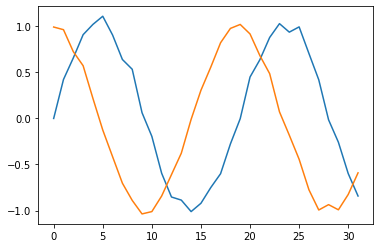

In [154]:
sample = next(iter(train_dataloader))
print(sample['fts'].shape)
print(sample['label'].shape)
plt.plot(sample["fts"][1,:,:])

In [155]:
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = spectral_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation), n_power_iterations=10)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = spectral_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation),n_power_iterations=10)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = spectral_norm(nn.Conv1d(n_inputs, n_outputs, 1), n_power_iterations=10) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()
    
    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)
    
    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]
 
        self.network = nn.Sequential(*layers)

    def  forward(self, x):
        return self.network(x)


class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)
        self.init_weights()
    
    def init_weights(self):
          self.linear.weight.data.normal_(0, 0.01)
      
    def forward(self, x, channel_last=True):
        #If channel_last, the expected format is (batch_size, seq_len, features)
        y1 = self.tcn(x.transpose(1, 2) if channel_last else x)
        return self.linear(y1.transpose(1, 2))



In [156]:
class CausalConvDiscriminator(nn.Module):

    def __init__(self, input_size, n_layers, n_channel, kernel_size, dropout=0):
        super().__init__()
        num_channels = [n_channel] * n_layers
        self.tcn = TCN(input_size, 1, num_channels, kernel_size, dropout)
        
    def forward(self, x, channel_last=True):
        return torch.sigmoid(self.tcn(x, channel_last))

class CausalConvGenerator(nn.Module):

    def __init__(self, noise_size, output_size, n_layers, n_channel, kernel_size, dropout=0):
        super().__init__()
        num_channels = [n_channel] * n_layers
        self.tcn = TCN(noise_size, output_size, num_channels, kernel_size, dropout)
        
    def forward(self, x, channel_last=True):
        return torch.tanh(self.tcn(x, channel_last))

In [157]:
def train(generator, discriminator, gen_optimizer, dis_optimizer, dim_z, sample):
    batch_size = sample['fts'].shape[0]

    criterion = nn.BCELoss().to(device)
    
    # https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628
    # 0.9 helps stabilizing according to this article
    real_label = torch.full((batch_size, window_size, 1), 0.1, device=device) 
    real_label = real_label.to(torch.float32)


    fake_label = torch.full((batch_size, window_size, 1), 0.9, device=device)
    fake_label = fake_label.to(torch.float32)

    sample_z = torch.randn(batch_size, window_size, dim_z, device=device)

    real_fts = sample['fts'].float().to(device)
    fake_fts = generator(sample_z)

    ############ Train Generator ###############################################

    generator.train()
    gen_optimizer.zero_grad()
   

    g_loss = criterion(discriminator(fake_fts), real_label)
    
    g_loss.backward()
    gen_optimizer.step()
    ############################################################################   
    
    ################# Train Discriminator ######################################
    discriminator.train()
    dis_optimizer.zero_grad()
    real_loss = criterion(discriminator(real_fts), real_label)


    fake_loss = criterion(discriminator(fake_fts.detach()), fake_label)
    d_loss = (real_loss + fake_loss) / 2

    d_loss.backward()
    dis_optimizer.step()    

    ############################################################################
    
    return g_loss.item(), d_loss.item()    

In [158]:
def test(generator, window_size, dim_z):
    generator.eval()
    with torch.no_grad():
        sample_z = torch.randn(1, window_size, dim_z, device=device)

        fake_fts = generator(sample_z)
   
    return fake_fts.detach().cpu().numpy()

In [159]:
in_dim = 100

generator = CausalConvGenerator(noise_size=in_dim, output_size=2, n_layers=8, n_channel=10, kernel_size=8, dropout=0.2).to(device)
discriminator = CausalConvDiscriminator(input_size=2, n_layers=8, n_channel=10, kernel_size=8, dropout=0).to(device)

gen_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
dis_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

[EPOCH 0] SAMPLED G LOSS : 0.6894683837890625, SAMPLED D LOSS : 0.6633058786392212


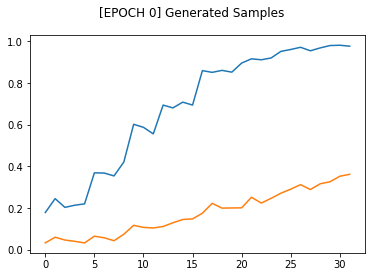

[EPOCH 10] SAMPLED G LOSS : 1.9061272144317627, SAMPLED D LOSS : 0.34498709440231323


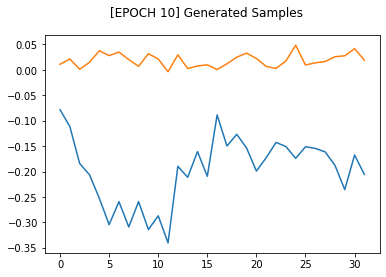

[EPOCH 20] SAMPLED G LOSS : 1.8598464727401733, SAMPLED D LOSS : 0.36825114488601685


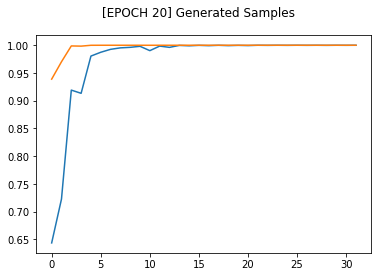

[EPOCH 30] SAMPLED G LOSS : 1.3286173343658447, SAMPLED D LOSS : 0.5190883278846741


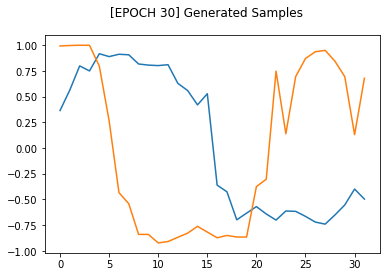

[EPOCH 40] SAMPLED G LOSS : 1.6638050079345703, SAMPLED D LOSS : 0.6941944360733032


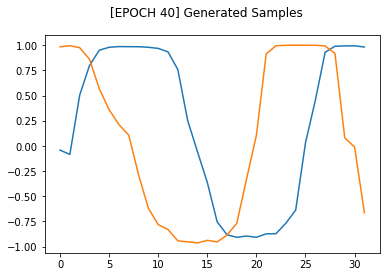

[EPOCH 50] SAMPLED G LOSS : 1.5167701244354248, SAMPLED D LOSS : 0.5097220540046692


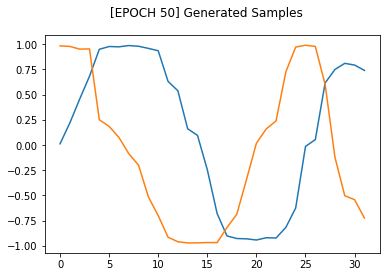

[EPOCH 60] SAMPLED G LOSS : 1.3802660703659058, SAMPLED D LOSS : 0.4728090465068817


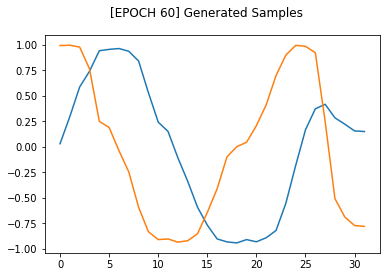

[EPOCH 70] SAMPLED G LOSS : 1.5315806865692139, SAMPLED D LOSS : 0.5207818746566772


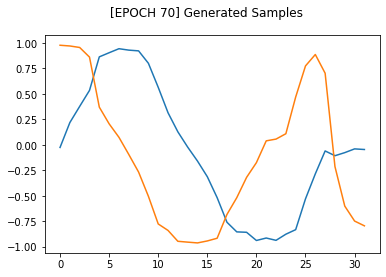

[EPOCH 80] SAMPLED G LOSS : 1.4220713376998901, SAMPLED D LOSS : 0.45657962560653687


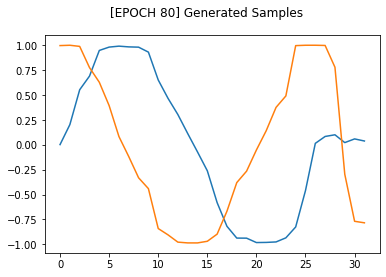

[EPOCH 90] SAMPLED G LOSS : 1.4867428541183472, SAMPLED D LOSS : 0.44269946217536926


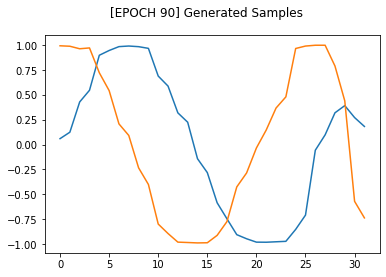

[EPOCH 100] SAMPLED G LOSS : 1.542938470840454, SAMPLED D LOSS : 0.4553412199020386


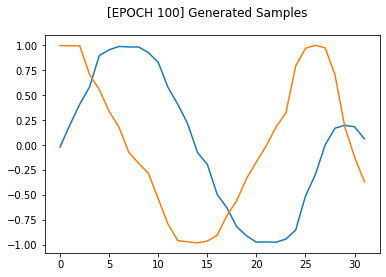

[EPOCH 110] SAMPLED G LOSS : 1.3631279468536377, SAMPLED D LOSS : 0.46120789647102356


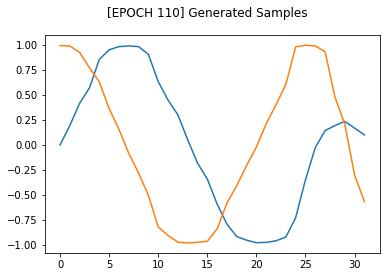

[EPOCH 120] SAMPLED G LOSS : 1.344972014427185, SAMPLED D LOSS : 0.43487048149108887


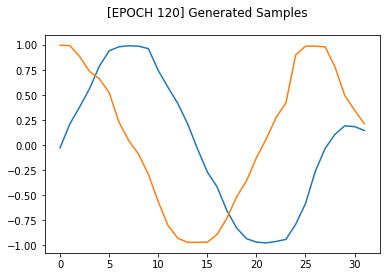

[EPOCH 130] SAMPLED G LOSS : 1.7319225072860718, SAMPLED D LOSS : 0.48975735902786255


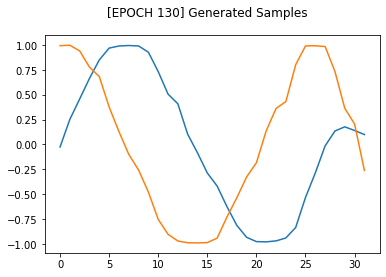

[EPOCH 140] SAMPLED G LOSS : 1.2471239566802979, SAMPLED D LOSS : 0.4521188735961914


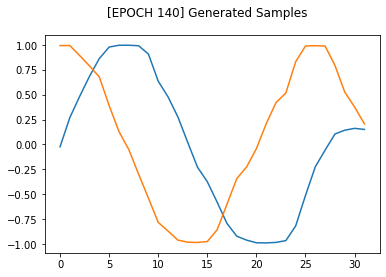

[EPOCH 150] SAMPLED G LOSS : 1.86772620677948, SAMPLED D LOSS : 0.4533933401107788


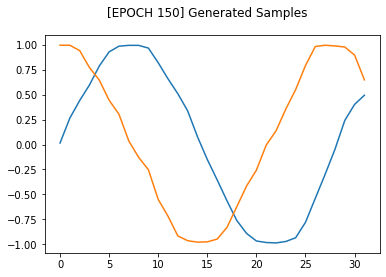

[EPOCH 160] SAMPLED G LOSS : 1.6236377954483032, SAMPLED D LOSS : 0.424478679895401


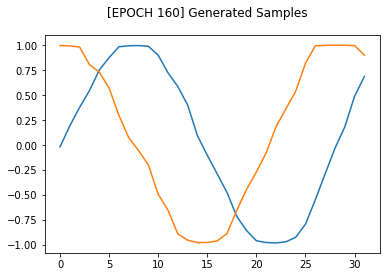

[EPOCH 170] SAMPLED G LOSS : 1.4760605096817017, SAMPLED D LOSS : 0.4181799292564392


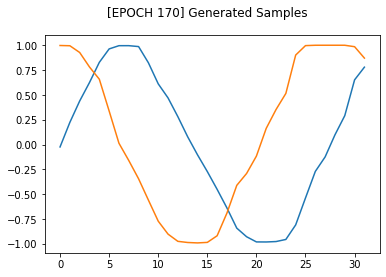

[EPOCH 180] SAMPLED G LOSS : 1.090948462486267, SAMPLED D LOSS : 0.46936261653900146


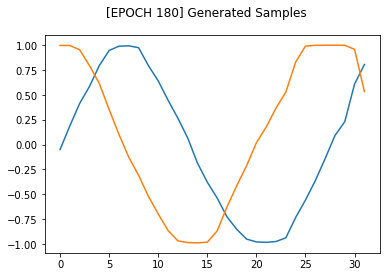

[EPOCH 190] SAMPLED G LOSS : 1.3935799598693848, SAMPLED D LOSS : 0.4240289032459259


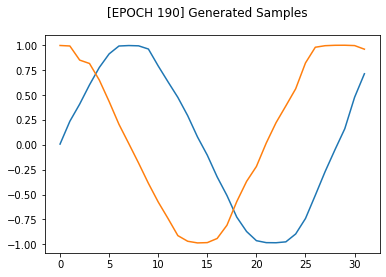

[EPOCH 200] SAMPLED G LOSS : 1.231307864189148, SAMPLED D LOSS : 0.4668366312980652


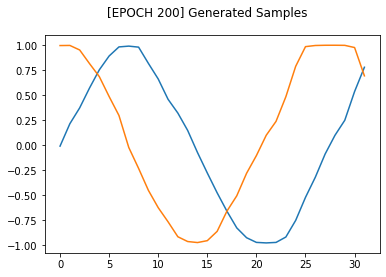

KeyboardInterrupt: ignored

In [160]:
max_epoch = 500
dim_z = in_dim

for epoch in tqdm(range(max_epoch)):        
    for idx, sample in enumerate(train_dataloader):
        g_loss, d_loss = train(generator, discriminator, gen_optimizer, dis_optimizer, dim_z, sample)
        
    if epoch % 10 == 0:
        print('[EPOCH {}] SAMPLED G LOSS : {}, SAMPLED D LOSS : {}'.format(epoch, g_loss, d_loss))
        plt.plot(test(generator, window_size, dim_z)[0,:,:])
        plt.suptitle('[EPOCH {}] Generated Samples'.format(epoch))
        plt.pause(0.1)